# **Spring 2025 Research Project - Transformer-Based Autism Diagnosis Prediction Using AQ10 Scores and Demographic Data**

### **Problem statement**: How can Transformer-based models be utilized to identify and analyze age-related patterns in AQ10 questionnaire responses to enhance the understanding of autism spectrum disorder (ASD) traits across different developmental stages?

### **Direction of visualization/application**:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Run this cell to download the adult dataset to notebook directory
from pathlib import Path
DATA_ROOT=Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset")
!kaggle datasets download -d andrewmvd/autism-screening-on-adults -p {DATA_ROOT}
!unzip { DATA_ROOT / Path('autism-screening-on-adults.zip') } -d {DATA_ROOT}

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults
License(s): other
autism-screening-on-adults.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism-screening-on-adults.zip
  inflating: /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism_screening.csv  


In [ ]:
#@title Run this cell to download the child dataset to notebook directory
from pathlib import Path
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
DATA_ROOT=Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset")
!kaggle datasets download -d uppulurimadhuri/dataset -p {DATA_ROOT}
!unzip { DATA_ROOT / Path('dataset.zip') } -d {DATA_ROOT}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/uppulurimadhuri/dataset
License(s): CC0-1.0
dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/dataset.zip
  inflating: /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/data_csv.csv  


In [33]:
### config.py

from pathlib import Path
import torch


class Config:
    SEED = 42
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # Data configuration
    PROJECT_PATH = Path("/content/drive/MyDrive/Projects/Spring-2025-Research")

    #
    RAW_ADULT_DATA_PATH = PROJECT_PATH / Path("dataset/autism_screening.csv")
    # https://www.kaggle.com/datasets/uppulurimadhuri/dataset/data
    RAW_CHILD_DATA_PATH = PROJECT_PATH / Path("dataset/data_csv.csv")

    PROCESSED_DATA_DIR = PROJECT_PATH / Path("dataset/processed")
    CHECKPOINT_DIR = PROJECT_PATH / Path("checkpoints")
    MODEL_DIR = PROJECT_PATH / Path("models")

    # Model hyperparameters
    MODEL_NAME = "bert-base-uncased"
    MODEL_DIM = 64
    NUM_LAYERS = 4
    DROPOUT = 0.2
    LEARNING_RATE = 0.0019167571149608848
    BATCH_SIZE = 64
    EPOCHS = 30

    # Data processing
    FEATURE_LEN = 12  # AQ10 scores + age + gender

    @classmethod
    def setup_directories(cls):
        cls.PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
        cls.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
        cls.MODEL_DIR.mkdir(parents=True, exist_ok=True)


## Data Preprocessing

In [29]:
child_df = (
    pl.read_csv(Config.RAW_CHILD_DATA_PATH)
    .drop(
        [
            "CASE_NO_PATIENT'S",
            "Social_Responsiveness_Scale",
            "Qchat_10_Score",
            "Speech Delay/Language Disorder",
            "Learning disorder",
            "Genetic_Disorders",
            "Depression",
            "Global developmental delay/intellectual disability",
            "Social/Behavioural Issues",
            "Childhood Autism Rating Scale",
            "Anxiety_disorder",
            "Ethnicity",
            "Jaundice",
            "Family_mem_with_ASD",
            "Who_completed_the_test",
        ]
    )
    .rename(
        {
            "A1": "A1_Score",
            "A2": "A2_Score",
            "A3": "A3_Score",
            "A4": "A4_Score",
            "A5": "A5_Score",
            "A6": "A6_Score",
            "A7": "A7_Score",
            "A8": "A8_Score",
            "A9": "A9_Score",
            "A10_Autism_Spectrum_Quotient": "A10_Score",
            "Age_Years": "age",
            "Sex": "gender",
            # "Jaundice": "jaundice",
            # "Ethnicity": "ethnicity",
            "ASD_traits": "diagnosis"
        }
    )
    .with_columns(
          [
              pl.when(pl.col("gender") == "M")
              .then(1)
              .otherwise(0)
              .alias("gender"),
              pl.when(pl.col("diagnosis") == "Yes")
              .then(1)
              .otherwise(0)
              .alias("diagnosis"),
              pl.col("age").cast(pl.Int64)
          ]
    )
)

len(child_df)

1985

In [3]:
### data_preprocessing.py

import polars as pl
from typing import Dict, List, Tuple
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import StratifiedShuffleSplit

# from config import Config


class DataProcessor:
    """Handles loading, preprocessing, and splitting of autism screening data using Polars."""

    def __init__(
        self,
        model_name: str = Config.MODEL_NAME,
    ):
        """
        Initialize the DataProcessor, set up tokenizer, etc.

        :param model_name: Name of the transformer model (e.g., 'bert-base-uncased')
        :param additional_special_tokens: Optional list of additional tokens to add to the tokenizer
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.add_special_tokens(
            {"additional_special_tokens": ["[DEMOGRAPHIC] ", "[/DEMOGRAPHIC]"]}
        )

    @staticmethod
    def load_raw_data() -> pl.DataFrame:
        """
        Load and preprocess raw data from CSV using Polars.
        Drops irrelevant columns and encodes certain fields as numeric.
        Return the cleaned Polars DataFrame.
        """
        adult_df = (
            pl.read_csv(Config.RAW_ADULT_DATA_PATH)
            .drop(
                [
                    "age_desc",
                    "ethnicity",
                    "jundice",
                    "contry_of_res",
                    "used_app_before",
                    "relation",
                    "Class/ASD"
                ]
            )
            .rename(
                {
                    "austim": "diagnosis",
                    # "jundice" : "jaundice"
                }
            )
            .with_columns(
                  [
                      pl.when(pl.col("gender") == "m")
                      .then(1)
                      .otherwise(0)
                      .alias("gender"),
                      pl.when(pl.col("diagnosis") == "yes")
                      .then(1)
                      .otherwise(0)
                      .alias("diagnosis"),
                      pl.col("age").cast(pl.Int64)
                  ]
            )
            .filter(pl.col("age").is_not_null())
        )

        child_df = (
            pl.read_csv(Config.RAW_CHILD_DATA_PATH)
            .drop(
                [
                    "CASE_NO_PATIENT'S",
                    "Social_Responsiveness_Scale",
                    "Qchat_10_Score",
                    "Speech Delay/Language Disorder",
                    "Learning disorder",
                    "Genetic_Disorders",
                    "Depression",
                    "Global developmental delay/intellectual disability",
                    "Social/Behavioural Issues",
                    "Childhood Autism Rating Scale",
                    "Anxiety_disorder",
                    "Ethnicity",
                    "Jaundice",
                    "Family_mem_with_ASD",
                    "Who_completed_the_test",
                ]
            )
            .rename(
                {
                    "A1": "A1_Score",
                    "A2": "A2_Score",
                    "A3": "A3_Score",
                    "A4": "A4_Score",
                    "A5": "A5_Score",
                    "A6": "A6_Score",
                    "A7": "A7_Score",
                    "A8": "A8_Score",
                    "A9": "A9_Score",
                    "A10_Autism_Spectrum_Quotient": "A10_Score",
                    "Age_Years": "age",
                    "Sex": "gender",
                    # "Jaundice": "jaundice",
                    # "Ethnicity": "ethnicity",
                    "ASD_traits": "diagnosis"
                }
            )
            .with_columns(
                  [
                      pl.when(pl.col("gender") == "M")
                      .then(1)
                      .otherwise(0)
                      .alias("gender"),
                      pl.when(pl.col("diagnosis") == "Yes")
                      .then(1)
                      .otherwise(0)
                      .alias("diagnosis"),
                      pl.col("age").cast(pl.Int64)
                  ]
            )
        )

        common_cols = list(set(adult_df.columns).intersection(set(child_df.columns)))
        adult_df = adult_df.select(common_cols)
        child_df = child_df.select(common_cols)

        raw_df = pl.concat(
          [adult_df, child_df], how="vertical"
        )

        counts = raw_df["diagnosis"].value_counts().to_dict()
        print(f"Class distribution: {counts}")

        return raw_df

    @staticmethod
    def split_data(df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
        """
        Split data into stratified train/val/test sets (70/15/15),
        preserving the diagnosis class distribution.
        """
        # Convert Polars DataFrame to pandas for StratifiedShuffleSplit
        pdf = df.to_pandas()

        # First split: train (70%) vs temp (30%)
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=Config.SEED)
        train_idx, temp_idx = next(sss1.split(pdf, pdf["diagnosis"]))
        train_pdf = pdf.iloc[train_idx]
        temp_pdf  = pdf.iloc[temp_idx]

        # Second split: temp → val (15%) and test (15%) of original
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=Config.SEED)
        val_idx, test_idx = next(sss2.split(temp_pdf, temp_pdf["diagnosis"]))
        val_pdf  = temp_pdf.iloc[val_idx]
        test_pdf = temp_pdf.iloc[test_idx]

        # Convert back to Polars
        train_df = pl.from_pandas(train_pdf)
        val_df   = pl.from_pandas(val_pdf)
        test_df  = pl.from_pandas(test_pdf)

        # Prepare feature / target splits
        return {
            "train_features": train_df.drop(["diagnosis"]),
            "train_targets":  train_df.select(["diagnosis"]),
            "val_features":   val_df.drop(["diagnosis"]),
            "val_targets":    val_df.select(["diagnosis"]),
            "test_features":  test_df.drop(["diagnosis"]),
            "test_targets":   test_df.select(["diagnosis"]),
        }

    @staticmethod
    def format_demographic_data(row: dict) -> str:
        """
        Convert demographic data into a string with special tokens.
        Adjust fields as appropriate for your data.
        E.g., row["age"], row["gender"], etc.
        """
        demographic_str = (
            f"[DEMOGRAPHIC] "
            f"Age: {row.get('age', '')}, "
            f"Gender: {row.get('gender', '')} "
            f"[/DEMOGRAPHIC]"
        )
        return demographic_str

    @staticmethod
    def format_aq10_responses(row: dict) -> str:
        """
        Convert the row's question responses (Q1..Q10) into a text format.
        Adjust as needed if your data has different question names.
        """
        responses = []
        for i in range(1, 11):
            col_name = f"A{i}_Score"
            if col_name in row:
                responses.append(f"Q{i}: {row[col_name]}")
            else:
                # If missing, you can adapt how to handle it (e.g., blank)
                responses.append(f"Q{i}: ")
        return " ".join(responses)

    def preprocess_data(
        self, df: pl.DataFrame, label_cols: List[str] = None
    ) -> Tuple[Dict[str, torch.Tensor], List]:
        """
        Preprocess the Polars DataFrame into tokenized input_ids & attention_masks.
        If label_cols is provided (e.g. ["diagnosis", "classification"]),
        returns labels; otherwise returns None for labels.

        :param df: Polars DataFrame
        :param label_cols: List of columns to treat as labels, e.g. ["diagnosis"].
        :return: (encodings, labels)
        """
        if label_cols is None:
            label_cols = []

        # Convert to list of dicts for easy iteration
        dict_rows = df.to_dicts()

        texts = []
        labels = []

        for row in dict_rows:
            # Format demographic info
            demographic_text = self.format_demographic_data(row)
            # Format AQ10 responses
            aq_text = self.format_aq10_responses(row)

            # Combine into one string
            full_text = demographic_text + " " + aq_text
            texts.append(full_text)

            # Gather labels if present
            if label_cols:
                # If label_cols is ["diagnosis"], we take row["diagnosis"]
                # If multiple columns, we store them as a tuple
                row_labels = tuple(row[col] for col in label_cols)
                labels.append(row_labels if len(label_cols) > 1 else row_labels[0])
            else:
                labels.append(None)

        # Tokenize the texts
        encodings = self.tokenizer(
            texts, truncation=True, padding=True, return_tensors="pt"
        )

        return encodings, labels


## Process Data

In [4]:
### dataset.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from typing import Dict
import multiprocessing as mp
from tqdm import tqdm


class ASDDataset(Dataset):
    """PyTorch Dataset for autism screening data with optional augmentation."""

    def __init__(self, feature_df, tgt_df, augment: bool = False):
        self.feature_df = feature_df.to_pandas(use_pyarrow_extension_array=True)
        self.tgt_df = tgt_df.to_pandas(use_pyarrow_extension_array=True)
        self.augment = augment

        self.age_min = self.feature_df["age"].min()
        self.age_max = self.feature_df["age"].max()
        self.keys = self.feature_df.index.tolist()
        self._precompute_features()

    def _precompute_features(self):
        """Precompute features for faster training."""
        self.tgt_arrays = {}
        self.feature_arrays = {}

        for key in self.keys:
            self.tgt_arrays[key] = self._transform_target(self.tgt_df.loc[key])
            self.feature_arrays[key] = self._transform_features(self.feature_df.loc[key])

    def _transform_features(self, row: pd.Series) -> np.ndarray:
        features = row[[f"A{i}_Score" for i in range(1, 11)] + ["age", "gender"]].copy()
        features["age"] = (features["age"] - self.age_min) / (self.age_max - self.age_min)
        return features.values.astype(np.float32)

    def _transform_target(self, row: pd.Series) -> np.ndarray:
        return np.array([row["diagnosis"]], dtype=np.float32)

    def _augment_features(self, features: np.ndarray) -> np.ndarray:
        # Gaussian noise only for AQ10 + age (exclude gender)
        aq_age = features[:-1]
        gender = features[-1:]

        noise = np.random.normal(loc=0.0, scale=0.05, size=aq_age.shape)
        aq_age = aq_age + noise

        # Optional: randomly mask one AQ score (simulate missing answer)
        if np.random.rand() < 0.2:
            idx = np.random.randint(0, 10)
            aq_age[idx] = 0.0

        return np.concatenate([aq_age, gender])

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        features = self.feature_arrays[key]
        target = self.tgt_arrays[key]
        if self.augment:
            features = self._augment_features(features)

        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        return features, target


## Model Implementation

In [5]:
!pip install pytorch-lightning
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 64.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitl

In [19]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
from pytorch_lightning import LightningModule
from torch.nn import TransformerEncoder, TransformerEncoderLayer
# from config import Config


class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0, reduction: str = 'mean'):
        super().__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = torch.exp(-bce)
        loss = self.alpha * (1 - p_t) ** self.gamma * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()


class Model(nn.Module):
    def __init__(
        self,
        use_text: bool = False,
        text_model_name: str = "bert-base-uncased",
        ablate_demographic: bool = False,
        pooling: str = "first",
    ):
        super().__init__()
        # 1) Numeric features setup
        base_len = Config.FEATURE_LEN                    # e.g. 12
        self.feature_len = base_len - 2 if ablate_demographic else base_len
        self.ablate_demographic = ablate_demographic
        self.pooling = pooling

        self.feature_norm = nn.BatchNorm1d(self.feature_len)
        self.feature_embedding = nn.Sequential(
            nn.Linear(1, Config.MODEL_DIM),
            nn.GELU(),
            nn.LayerNorm(Config.MODEL_DIM),
        )
        self.positional_embedding = nn.Parameter(
            torch.randn(self.feature_len, Config.MODEL_DIM)
        )

        dim_feedforward = Config.MODEL_DIM * 4
        num_heads = max(2, Config.MODEL_DIM // 16)
        encoder_layer = TransformerEncoderLayer(
            d_model=Config.MODEL_DIM,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=Config.DROPOUT,
            batch_first=True,
        )
        self.encoder = TransformerEncoder(
            encoder_layer, num_layers=Config.NUM_LAYERS
        )
        self.dropout = nn.Dropout(Config.DROPOUT)

        # 2) Optional text encoder
        self.use_text = use_text
        if use_text:
            self.text_encoder = AutoModel.from_pretrained(text_model_name)
            text_hidden = self.text_encoder.config.hidden_size
        else:
            text_hidden = 0

        # 3) Classification head on fused dimension
        fused_dim = Config.MODEL_DIM + text_hidden
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Linear(fused_dim, fused_dim // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(fused_dim // 2, 1),
        )

    def forward(
        self,
        x_numeric: torch.Tensor,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
    ):
        # Optionally drop demographic columns
        x = x_numeric[:, :self.feature_len] if self.ablate_demographic else x_numeric

        # Numeric transformer pathway
        x = self.feature_norm(x)
        x = x.unsqueeze(-1)
        x = self.feature_embedding(x)
        x = x + self.positional_embedding.unsqueeze(0)
        x = self.encoder(x)
        x = self.dropout(x)
        if self.pooling == "first":
            num_rep = x[:, 0]
        elif self.pooling == "mean":
            num_rep = x.mean(dim=1)
        else:
            raise ValueError(f"Unknown pooling mode {self.pooling}")

        # Text pathway + fusion
        if self.use_text:
            txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            txt_rep = txt_out.last_hidden_state[:, 0, :]
            feat = torch.cat([num_rep, txt_rep], dim=1)
        else:
            feat = num_rep

        logits = self.classifier_head(feat).squeeze(-1)
        return logits


class LitModel(LightningModule):
    def __init__(
        self,
        pos_weight: torch.Tensor,
        gamma: float = 2.0,
        use_text: bool = False,
        text_model_name: str = "bert-base-uncased",
        ablate_demographic: bool = False,
        pooling: str = "first",
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = Model(
            use_text=use_text,
            text_model_name=text_model_name,
            ablate_demographic=ablate_demographic,
            pooling=pooling,
        )
        self.loss_fn = FocalLoss(alpha=pos_weight, gamma=gamma)
        self.f1 = BinaryF1Score(threshold=0.5)
        self.precision = BinaryPrecision(threshold=0.5)
        self.recall = BinaryRecall(threshold=0.5)

    def forward(self, x_numeric, input_ids=None, attention_mask=None):
        return self.model(x_numeric, input_ids=input_ids, attention_mask=attention_mask)

    def step(self, batch, batch_idx, stage: str):
        if self.hparams.use_text:
            x_num, enc, y = batch
            logits = self(x_num, **enc)
        else:
            x_num, y = batch
            logits = self(x_num)

        loss = self.loss_fn(logits, y.squeeze())
        preds = torch.sigmoid(logits) > 0.5

        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_f1", self.f1(preds, y.squeeze()), prog_bar=True)
        self.log(f"{stage}_precision", self.precision(preds, y.squeeze()))
        self.log(f"{stage}_recall", self.recall(preds, y.squeeze()))

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=Config.LEARNING_RATE)


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import joblib
from pathlib import Path


class BaselineModels:
    def __init__(self, train_features, train_targets, test_features, test_targets):
        self.models = {
            "SVM": SVC(probability=True, kernel="rbf"),
            "Decision Tree": DecisionTreeClassifier(max_depth=5),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "Naive Bayes": GaussianNB(),
            "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=2000),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
            "LightGBM": LGBMClassifier(),
        }
        self.train_features = train_features
        self.train_targets = train_targets
        self.test_features = test_features
        self.test_targets = test_targets
        self.results = []

    def train_and_evaluate(self):
        """Train all baseline models and evaluate performance"""
        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Train on diagnosis task
            model.fit(self.train_features, self.train_targets[:, 0])
            diag_preds = model.predict(self.test_features)

            # Train on classification task
            model.fit(self.train_features, self.train_targets[:, 1])
            class_preds = model.predict(self.test_features)

            # Store results
            self.results.append(
                {
                    "Model": name,
                    "Diagnosis Accuracy": accuracy_score(
                        self.test_targets[:, 0], diag_preds
                    ),
                    "Diagnosis F1": f1_score(self.test_targets[:, 0], diag_preds),
                    "Classification Accuracy": accuracy_score(
                        self.test_targets[:, 1], class_preds
                    ),
                    "Classification F1": f1_score(self.test_targets[:, 1], class_preds),
                }
            )

            # Save models
            joblib.dump(
                model, Config.MODEL_DIR / f"{name.lower().replace(' ', '_')}.joblib"
            )

        return pd.DataFrame(self.results)

    def generate_report(self, transformer_metrics):
        """Generate comparison report with transformer model"""
        baseline_df = pd.DataFrame(self.results)

        # Add transformer results
        transformer_row = {
            "Model": "Transformer",
            "Diagnosis Accuracy": transformer_metrics["diagnosis_accuracy"],
            "Diagnosis F1": transformer_metrics["diagnosis_f1"],
            "Classification Accuracy": transformer_metrics["class_accuracy"],
            "Classification F1": transformer_metrics["class_f1"],
        }

        return pd.concat(
            [baseline_df, pd.DataFrame([transformer_row])], ignore_index=True
        )


In [21]:
def train_baselines(train_dataset, test_dataset):
    """
    Trains the baseline models.
    Uses the entire train_dataset for training and test_dataset for evaluation.
    Results are printed and models are saved as .joblib files.
    """
    # Convert train_dataset to NumPy
    train_features = np.array([sample[0] for sample in train_dataset])
    train_targets = np.array([sample[1] for sample in train_dataset])

    # Convert test_dataset to NumPy
    test_features = np.array([sample[0] for sample in test_dataset])
    test_targets = np.array([sample[1] for sample in test_dataset])

    # Initialize BaselineModels
    baselines = BaselineModels(
        train_features, train_targets, test_features, test_targets
    )
    # Train and evaluate
    df_results = baselines.train_and_evaluate()

    print("\nBaseline Models Training Complete.")
    print("Baseline performance on test set:\n", df_results)


In [38]:
### train.py

import pickle
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import optuna
import optuna

# from config import Config
# from data_preprocessing import DataProcessor
# from dataset import ASDDataset
# from model import LitModel


def compute_pos_weight(targets_tensor: torch.Tensor) -> torch.Tensor:
    """
    Compute positive weight for BCEWithLogitsLoss to address class imbalance.
    pos_weight = num_neg / num_pos
    """
    total = targets_tensor.numel()
    pos = torch.sum(targets_tensor)
    neg = total - pos
    weight = neg / (pos + 1e-6)
    return torch.tensor(min(weight.item(), 5.0))  # clip to prevent over-weighting


def train():
    # Setup
    Config.setup_directories()
    processor = DataProcessor()

    print("Loading and processing raw data...")
    raw_df = processor.load_raw_data()
    splits = processor.split_data(raw_df)

    # Compute pos_weight
    train_targets_tensor = torch.tensor(
        splits["train_targets"]["diagnosis"].to_numpy(), dtype=torch.float32
    )
    pos_weight = compute_pos_weight(train_targets_tensor)

    # Build datasets
    train_dataset = ASDDataset(splits["train_features"], splits["train_targets"], augment=True)
    val_dataset   = ASDDataset(splits["val_features"],   splits["val_targets"])
    test_dataset  = ASDDataset(splits["test_features"],  splits["test_targets"])

    # ── OVERSAMPLING ──
    labels        = [int(y.item()) for _, y in train_dataset]
    class_counts  = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[l] for l in labels]
    sampler       = WeightedRandomSampler(sample_weights,
                                          num_samples=len(sample_weights),
                                          replacement=True)

    # Save preprocessed datasets
    for name, ds in zip(["train", "val", "test"],
                        [train_dataset, val_dataset, test_dataset]):
        with open(Config.PROCESSED_DATA_DIR / f"{name}_dataset.pkl", "wb") as f:
            pickle.dump(ds, f)

    # DataLoaders (use sampler for train)
    train_loader = DataLoader(train_dataset,
                              batch_size=Config.BATCH_SIZE,
                              sampler=sampler,
                              num_workers=4,
                              drop_last=True)
    val_loader   = DataLoader(val_dataset,
                              batch_size=Config.BATCH_SIZE,
                              num_workers=4)
    test_loader  = DataLoader(test_dataset,
                              batch_size=Config.BATCH_SIZE,
                              num_workers=4)

    # Model
    model = LitModel(pos_weight=pos_weight)

    # ── Loggers ──
    tb_logger  = TensorBoardLogger(save_dir="tb_logs",
                                   name="ASD_Transformer",
                                   default_hp_metric=False)
    csv_logger = CSVLogger     (save_dir="csv_logs",
                                name="ASD_Transformer")

    # Callbacks: checkpoint on best val_f1, early stop on val_f1
    checkpoint_callback = ModelCheckpoint(
        dirpath=Config.CHECKPOINT_DIR,
        filename="best-{epoch:02d}-{val_f1:.4f}",
        monitor="val_f1",
        mode="max",
        save_top_k=1,
    )
    early_stop_callback = EarlyStopping(
        monitor="val_f1",
        patience=5,
        mode="max"
    )

    # Trainer: attach both loggers
    trainer = Trainer(
        max_epochs=Config.EPOCHS,
        accelerator="auto",
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=[tb_logger, csv_logger],
        log_every_n_steps=1,
    )

    # ── Training ──
    print("Starting training...")
    trainer.fit(model, train_loader, val_loader)

    # ── Plot training curves from CSV logs ──
    metrics_path = f"{csv_logger.log_dir}/metrics.csv"
    df = pd.read_csv(metrics_path)
    epoch_df = df.groupby("epoch").mean().reset_index()

    plt.figure()
    plt.plot(epoch_df["epoch"], epoch_df["train_loss_step"], label="Train Loss")
    plt.plot(epoch_df["epoch"], epoch_df["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.title("Loss vs Epoch")
    plt.show()

    plt.figure()
    plt.plot(epoch_df["epoch"], epoch_df["train_f1"], label="Train F1")
    plt.plot(epoch_df["epoch"], epoch_df["val_f1"],   label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("F1 Score"); plt.legend()
    plt.title("F1 Score vs Epoch")
    plt.show()

    # ── Final Evaluation ──
    print("Testing model on held-out set...")
    results = trainer.test(model, test_loader)
    print("Test results:", results)


def objective(trial):
    # 1) Suggest a learning rate between 1e-5 and 1e-2
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)

    # 2) Reload data splits (or cache outside this function if you prefer)
    processor = DataProcessor()
    raw_df = processor.load_raw_data()
    splits = processor.split_data(raw_df)
    train_ds = ASDDataset(splits["train_features"], splits["train_targets"], augment=True)
    val_ds   = ASDDataset(splits["val_features"],   splits["val_targets"])

    # 3) Compute pos_weight for FocalLoss or BCEWithLogitsLoss
    train_labels = [int(y.item()) for _, y in train_ds]
    pos_weight = (len(train_labels) - sum(train_labels)) / (sum(train_labels) + 1e-6)
    pos_weight = np.clip(pos_weight, 1.0, 5.0)
    pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

    # 4) (Optional) Oversample positives
    class_counts  = np.bincount(train_labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights,
                                    num_samples=len(sample_weights),
                                    replacement=True)
    train_loader = DataLoader(train_ds,
                              batch_size=Config.BATCH_SIZE,
                              sampler=sampler,
                              num_workers=4,
                              drop_last=True)
    val_loader   = DataLoader(val_ds,
                              batch_size=Config.BATCH_SIZE,
                              num_workers=4)

    # 5) Instantiate model with this trial's LR
    model = LitModel(pos_weight=pos_weight)
    model.hparams.lr = lr  # override default LR

    # 6) Set up a Trainer that logs val_loss
    checkpoint_cb = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath=str(Config.CHECKPOINT_DIR),
        filename="optuna-{epoch:02d}-{val_loss:.4f}"
    )
    earlystop_cb = EarlyStopping(monitor="val_loss", patience=3, mode="min")
    trainer = Trainer(
        max_epochs=Config.EPOCHS,
        accelerator="auto",
        devices=1,
        callbacks=[checkpoint_cb, earlystop_cb],
        logger=False,
    )

    # 7) Train & fetch validation loss
    trainer.fit(model, train_loader, val_loader)
    val_loss = trainer.callback_metrics["val_loss"].item()

    # Report intermediate result to Optuna
    trial.report(val_loss, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss


Loading and processing raw data...
Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

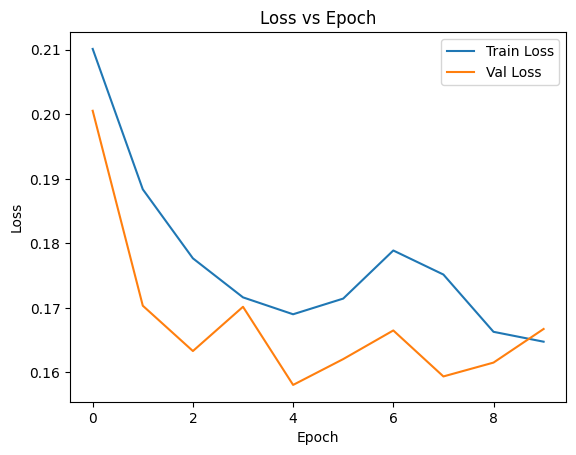

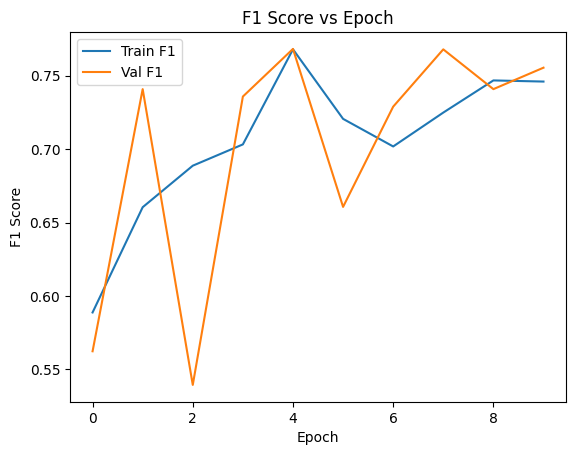

Testing model on held-out set...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.6886805295944214     │
│         test_loss         │    0.1906599998474121     │
│      test_precision       │    0.6220620274543762     │
│        test_recall        │    0.7780076861381531     │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_loss': 0.1906599998474121, 'test_f1': 0.6886805295944214, 'test_precision': 0.6220620274543762, 'test_recall': 0.7780076861381531}]


In [39]:
train()

In [31]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=20)

print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f" • {k}: {v}")

[I 2025-05-07 06:35:06,527] A new study created in memory with name: no-name-cac48fda-e54f-4b4d-8a15-d4abb70c36fe
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:35:31,263] Trial 0 finished with value: 0.15056118369102478 and parameters: {'lr': 1.7066480114997156e-05}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:35:51,888] Trial 1 finished with value: 0.1585991382598877 and parameters: {'lr': 0.009490963162896646}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:36:04,112] Trial 2 finished with value: 0.15816475450992584 and parameters: {'lr': 6.305791406379143e-05}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:36:20,245] Trial 3 finished with value: 0.15675508975982666 and parameters: {'lr': 0.0091990365795482}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:36:48,704] Trial 4 finished with value: 0.1612716019153595 and parameters: {'lr': 0.00019351960356653444}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:37:07,362] Trial 5 finished with value: 0.1532829850912094 and parameters: {'lr': 0.000316848480964187}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:37:31,649] Trial 6 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:37:51,675] Trial 7 finished with value: 0.15456992387771606 and parameters: {'lr': 1.8859000389455456e-05}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:38:27,429] Trial 8 finished with value: 0.1512918919324875 and parameters: {'lr': 0.00025301415704559655}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:38:52,747] Trial 9 finished with value: 0.15267851948738098 and parameters: {'lr': 0.0008183343878768876}. Best is trial 0 with value: 0.15056118369102478.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:39:10,087] Trial 10 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:39:39,227] Trial 11 finished with value: 0.15040533244609833 and parameters: {'lr': 0.0014422616083930408}. Best is trial 11 with value: 0.15040533244609833.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:40:13,204] Trial 12 finished with value: 0.14799869060516357 and parameters: {'lr': 0.0016280393360476573}. Best is trial 12 with value: 0.14799869060516357.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:40:47,304] Trial 13 finished with value: 0.14738722145557404 and parameters: {'lr': 0.0019167571149608848}. Best is trial 13 with value: 0.14738722145557404.
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:41:02,323] Trial 14 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:41:17,552] Trial 15 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	1
	0
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1165
	1522
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:41:45,658] Trial 16 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:42:09,632] Trial 17 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:42:24,757] Trial 18 pruned. 
<ipython-input-22-f96aefcffd45>:107: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


Class distribution: {'diagnosis': shape: (2,)
Series: 'diagnosis' [i32]
[
	0
	1
], 'count': shape: (2,)
Series: 'count' [u32]
[
	1522
	1165
]}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Model           | 203 K  | train
1 | loss_fn   | FocalLoss       | 0      | train
2 | f1        | BinaryF1Score   | 0      | train
3 | precision | BinaryPrecision | 0      | train
4 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total estimat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-07 06:42:55,180] Trial 19 pruned. 


Best hyperparameters:
 • lr: 0.0019167571149608848


## Evaluating model

In [42]:
### evaluate.py

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)

# from config import Config
# from model import LitModel
from pathlib import Path


def evaluate_transformer():
    """
    Loads the best Transformer checkpoint and evaluates it on the test dataset.
    Prints accuracy, precision, recall, F1, confusion matrix, ROC, and PR curves.
    """
    # Load test dataset
    with open(Config.PROCESSED_DATA_DIR / "test_dataset.pkl", "rb") as f:
        test_dataset = pickle.load(f)

    # Create DataLoader
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=Config.BATCH_SIZE, num_workers=4
    )

    # Load trained model from best checkpoint
    ckpt_path = Path(Config.CHECKPOINT_DIR) / "best-checkpoint-v23.ckpt"
    print(f"Loading Transformer checkpoint from: {ckpt_path}")
    model = LitModel.load_from_checkpoint(str(ckpt_path))
    model.eval()

    # Accumulate predictions
    y_true, y_pred_probs = [], []

    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x)
            y_true.extend(y.cpu().numpy())
            y_pred_probs.extend(torch.sigmoid(logits).cpu().numpy())

    # Convert to binary predictions
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # ─── Find optimal threshold by maximizing F1 ───
    thresholds = np.linspace(0.1, 0.9, 81)
    f1s = [f1_score(y_true, (y_pred_probs > t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    print(f"\nBest F1 threshold on test set: {best_t:.2f}")

    y_pred = y_pred_probs > 0.5

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    print(f"\nModel Metrics:")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")

    def print_metrics(y_true, y_pred, y_probs, task_name='Model'):

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{task_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", lw=2)
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {task_name}")
        plt.legend()
        plt.show()

        # Precision-Recall Curve
        precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
        pr_auc = auc(recall_vals, precision_vals)
        plt.figure()
        plt.plot(recall_vals, precision_vals, label=f"PR AUC = {pr_auc:.2f}", lw=2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {task_name}")
        plt.legend()
        plt.show()

    print_metrics(y_true, y_pred, y_pred_probs)



def evaluate_baselines():
    """
    Loads each trained baseline model (.joblib) from the 'models' folder
    and evaluates on the test dataset, printing accuracy, precision, recall, and F1 results.
    """
    # Load test dataset
    with open(Config.PROCESSED_DATA_DIR / "test_dataset.pkl", "rb") as f:
        test_dataset = pickle.load(f)

    # Convert test dataset to numpy
    test_features = np.array([sample[0] for sample in test_dataset])
    test_targets = np.array([sample[1] for sample in test_dataset])

    # List of known baseline model filenames
    possible_models = [
        "svm.joblib",
        "decision_tree.joblib",
        "random_forest.joblib",
        "logistic_regression.joblib",
        "knn.joblib",
        "naive_bayes.joblib",
        "mlp.joblib",
        "xgboost.joblib",
        "lightgbm.joblib"
    ]
    evaluations = []

    # print("\nEvaluating Baseline Models...")
    for filename in possible_models:
        model_path = Config.MODEL_DIR / filename
        if not model_path.exists():
            print(f"Model file not found: {model_path}")
            continue

        model = joblib.load(model_path)
        model_name = filename.replace(".joblib", "").title().replace("_", " ")

        # Evaluate on 'diagnosis' (column 0)
        diag_preds = model.predict(test_features)
        diag_acc = accuracy_score(test_targets[:, 0], diag_preds)
        diag_prec = precision_score(test_targets[:, 0], diag_preds)
        diag_rec = recall_score(test_targets[:, 0], diag_preds)
        diag_f1 = f1_score(test_targets[:, 0], diag_preds)

        # Evaluate on 'classification' (column 1)
        # For consistency, we do not want to re-fit the model on test data,
        # but if you want each baseline to be separately trained for classification:
        # just call model.fit(train_features, train_targets[:, 1]) in train.py
        # or load a second saved model. For demonstration, we'll just do .predict here.
        class_preds = model.predict(test_features)
        class_acc = accuracy_score(test_targets[:, 1], class_preds)
        class_prec = precision_score(test_targets[:, 1], class_preds)
        class_rec = recall_score(test_targets[:, 1], class_preds)
        class_f1 = f1_score(test_targets[:, 1], class_preds)

        # print(f"\n{model_name} Baseline:")
        # print(f" Diagnosis -> Acc: {diag_acc:.4f}, Precision: {diag_prec:.4f}, Recall: {diag_rec:.4f}, F1: {diag_f1:.4f}")
        # print(f" Classification -> Acc: {class_acc:.4f}, Precision: {class_prec:.4f}, Recall: {class_rec:.4f}, F1: {class_f1:.4f}")
        evaluations.append({
            "model_name": model_name,
            "diagnosis_accuracy": diag_acc,
            "diagnosis_precision": diag_prec,
            "diagnosis_recall": diag_rec,
            "diagnosis_f1": diag_f1,
            "class_accuracy": class_acc,
            "class_precision": class_prec,
            "class_recall": class_rec,
            "class_f1": class_f1,
        })
    return evaluations


Evaluating Transformer model...
Loading Transformer checkpoint from: /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v23.ckpt

Best F1 threshold on test set: 0.44

Model Metrics:
 Accuracy:  0.7252
 Precision: 0.6495
 Recall:    0.7943
 F1 Score:  0.7147


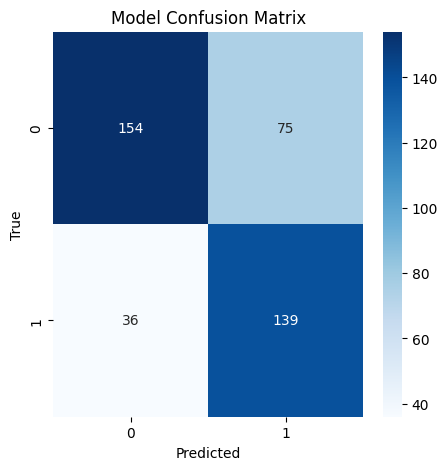

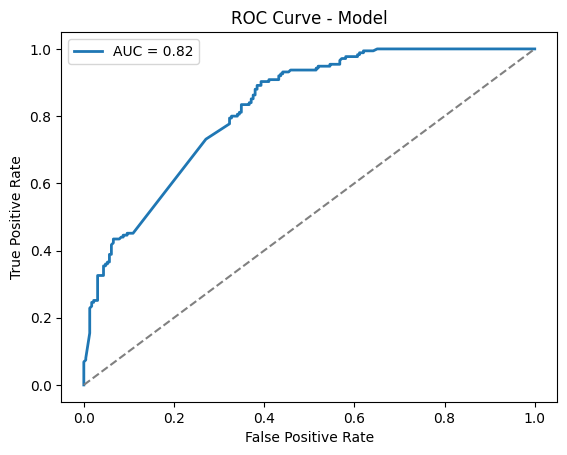

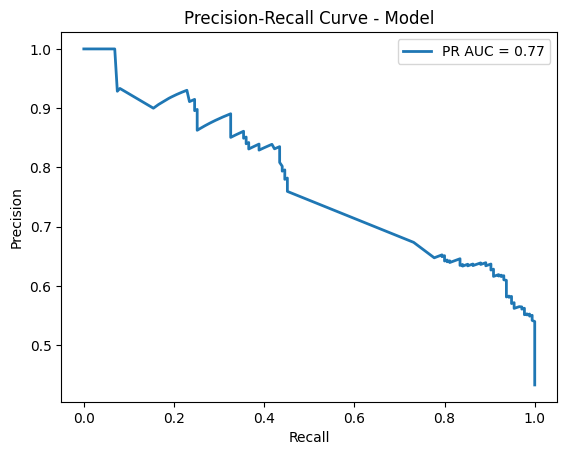

In [43]:
print("Evaluating Transformer model...")
transformer_metrics = evaluate_transformer()

In [ ]:
print("\nEvaluating Baseline models...")
evaluations_baselines = evaluate_baselines()
pd.DataFrame(evaluations_baselines + transformer_metrics)


Evaluating Baseline models...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,model_name,diagnosis_accuracy,diagnosis_precision,diagnosis_recall,diagnosis_f1,class_accuracy,class_precision,class_recall,class_f1
0,Svm,0.754717,0.185185,0.555556,0.277778,0.943396,1.000000,0.818182,0.900000
1,Decision Tree,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
2,Random Forest,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
4,Knn,0.735849,0.172414,0.555556,0.263158,0.924528,0.931034,0.818182,0.870968
5,Naive Bayes,0.849057,0.111111,0.111111,0.111111,0.773585,1.000000,0.272727,0.428571
6,Mlp,0.792453,0.240000,0.666667,0.352941,0.924528,1.000000,0.757576,0.862069
7,Xgboost,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
8,Lightgbm,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
9,Transformer,0.915094,0.000000,0.000000,0.000000,0.981132,0.942857,1.000000,0.970588
